### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL - Exercise Sheet #08

#### Name:

In [29]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy

## Preparation: Load data

In [30]:
fname = 'imagVPaw.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)


## Exercise 1: Implement Common Spatial Pattern (CSP) Analysis  (4 points)
Implement a function for performing a common spatial pattern (CSP) analysis of two-class input data.

In [39]:
def train_CSP(epo, mrk_class):
    ''' 
    Usage:
        W, d = trainCSP(epo, mrk_class)
    Parameters:
        epo:   a 3D array of segmented signals (samples x channels x epochs)
        mrk_class: a 1D array that assigns markers to classes (0, 1)
    Returns:
        W:     matrix of spatial filters
        d:     vector of generalized Eigenvalues
    '''
    l_trials = np.hstack(epo[:, :, mrk_class==0])
    r_trials = np.hstack(epo[:, :, mrk_class==1])
    
    a = np.cov(l_trials)
    b = np.cov(r_trials)
    
    covs = np.dstack((a,b))
    D, W = sp.linalg.eigh(covs[:,:,0], covs.sum(2))
    
    return W, D

In [40]:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, [-100,1000])

W, D = train_CSP(epo, mrk_class)


## Exercise 2: Perform CSP Analysis on Motor Imagery Data  (3 points)
Apply a band-pass filter to the given (continuous) EEG signals with pass-band [10.5 13.] Hz, or use your findings of exercises \#1 on the last sheet to define the frequency band. Perform a CSP analysis for the time interval 750-4000 ms.
Plot the generalized Eigenvalues corresponding to both classes in one plot and select the 6 CSP filters for which the best discrimination can be expected according to the Eigenvalues. Apply the six spatial filters to the band-pass filtered EEG signals. The resulting signals are subsequently called CSP-filtered signals.

(6, 282838)


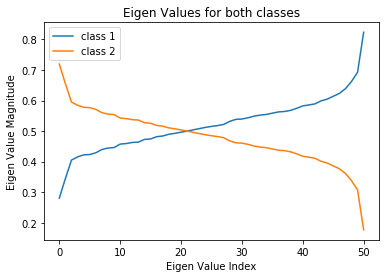

In [55]:
band = np.array([10.5, 13.])

Wn = band / fs * 2
b, a = scipy.signal.butter(5, Wn, btype='bandpass')
cnt_flt = sp.signal.lfilter(b, a, cnt)

epo, epo_t = bci.makeepochs(cnt_flt, fs, mrk_pos, [750,4000])

W, D = train_CSP(epo, mrk_class)

plt.plot(D, label = 'class 1')
plt.plot(1-D, label = 'class 2')
plt.xlabel("Eigen Value Index")
plt.ylabel("Eigen Value Magnitude")
plt.legend()
plt.title("Eigen Values for both classes")

idx=[0,1,2,-1,-2,-3]
W_csp = W[:,idx]
cnt_csp_filtered = W_csp.T.dot(cnt)

## Exercise 3:  Visualizing of CSP Patterns and ERD Curves  (4 points)
Visualize the six spatial patterns corresponding to the CSP filters as topographies. (If you did not succeed with exercise \#1 or \#2, download the file `imagVPaw_csp}` from the course page, which includes the full filter matrix $\bf W$ and Eigenvalues $\bf d$).
Take the CSP-filtered signals and visualize the classwise averaged ERD/ERS curves in the 6 channels.
Use the time interval from -500 ms to 6000 ms. Determine from these curves a time interval which shows a good discrimination of between the two motor imagery conditions for subsequent tasks.
**Note:** It would be better to use $r^2$-values for this purpose, but we skip that for this exercise.

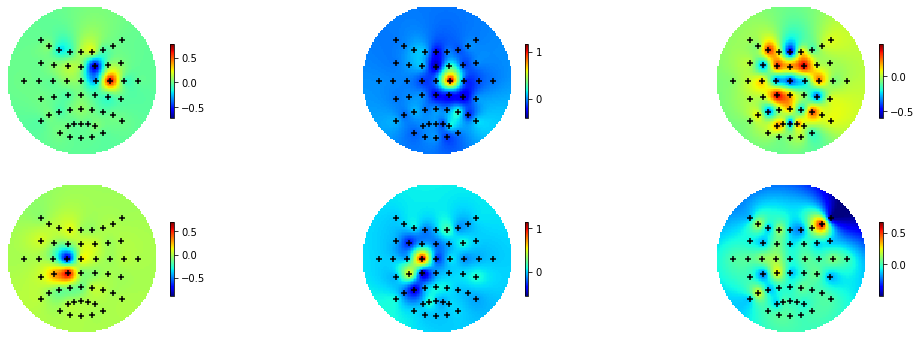

In [50]:
plt.figure(figsize=[18, 6])
for i in range(6):
    plt.subplot(2,3,i+1)
    bci.scalpmap(mnt, W_csp[:,i])

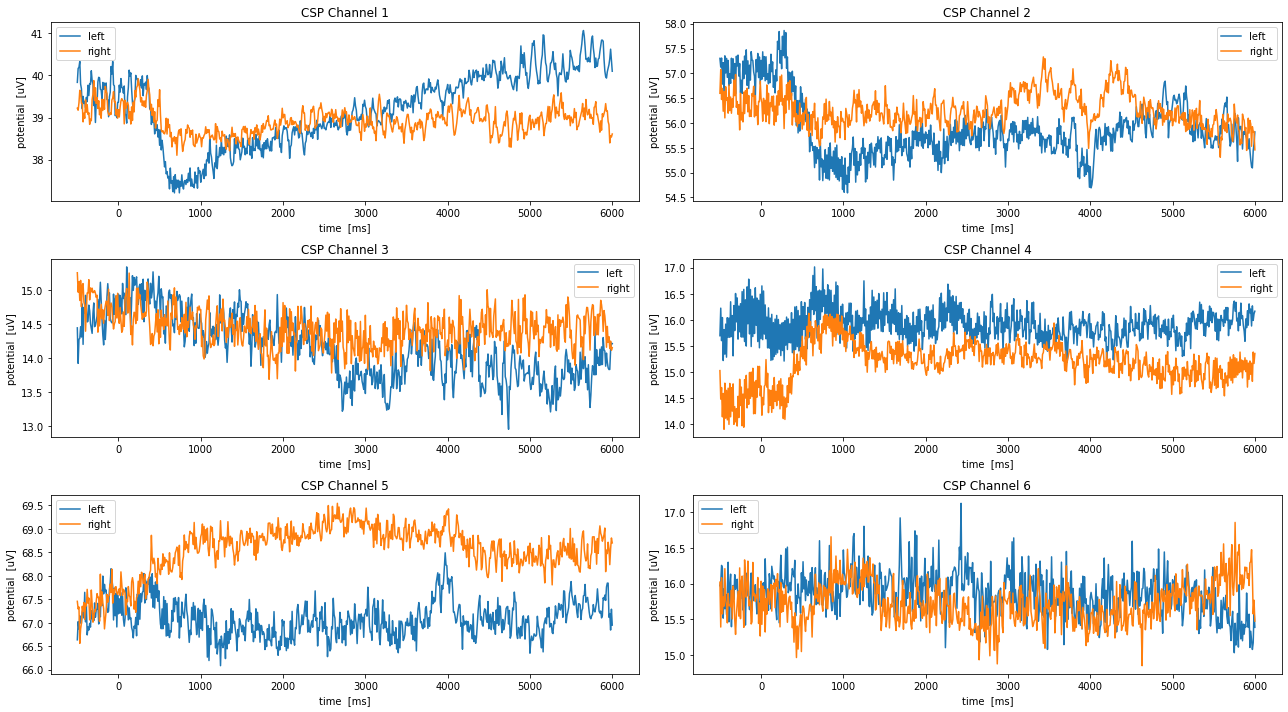

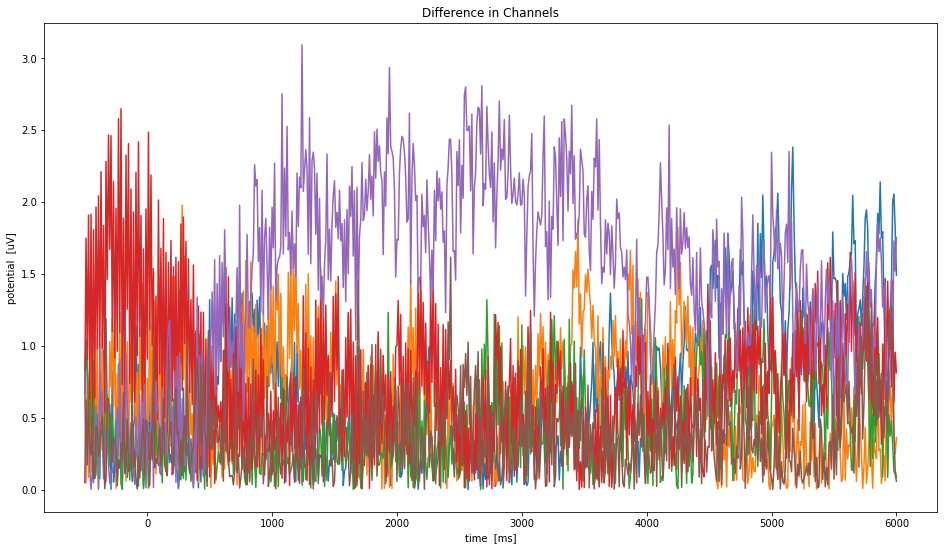

In [51]:
erd, erd_t = bci.makeepochs(cnt_csp_filtered, fs, mrk_pos, [-500, 6000])
erd = np.abs(erd)
erd0 = np.mean(erd[:,:,mrk_class==0], axis=2)
erd1 = np.mean(erd[:,:,mrk_class==1], axis=2)

plt.figure(figsize=[18, 10])
nChans= cnt_csp_filtered.shape[0]

for i in range(nChans):
    plt.subplot(3,2,i+1)
    plt.plot(erd_t, erd0[:, i], label=mrk_className[0])
    plt.plot(erd_t, erd1[:, i], label=mrk_className[1])
    plt.title('CSP Channel %d' % (i+1))
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')
    plt.legend()
    plt.tight_layout()

plt.figure(figsize=[16, 9])
for i in range(nChans):
    plt.plot(erd_t, np.abs(erd0[:, i] - erd1[:, i]))
    plt.title('Difference in Channels')
    plt.xlabel('time  [ms]')
    plt.ylabel('potential  [uV]')

## Exercise 4: Visualization of log band-power Features  (4 points)
Take the CSP-filtered signals, extract single trials in the time interval determined in exercise \#3 (or 750-4000 ms if you did not succeed) and calculate the log variance within each trial. Make a figure with six subplots, in which for each CSP-channel, the log band-power values are shown (trials on $x$-axis, log bp on $y$ axis).
Calculate the signed r^2-values for each of the six features and add them as title of the subplots. 
Determine log band-power values for each trial and channel (without CSP filter), calculate the r^2-values for each channel and display the result as topography.

In [52]:
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    epo0 = epo[:, :, y==0]
    epo1 = epo[:, :, y==1]
    N1 = epo0.shape[2]
    N2 = epo1.shape[2]
    const = np.float(N1*N2) / ((N1+N2)**2)
    mudiff = epo0.mean(axis=2) - epo1.mean(axis=2)
    var = epo.var(axis=2)
    return np.sign(mudiff) * const * (mudiff)**2 / var

(6, 280)
(51, 6)


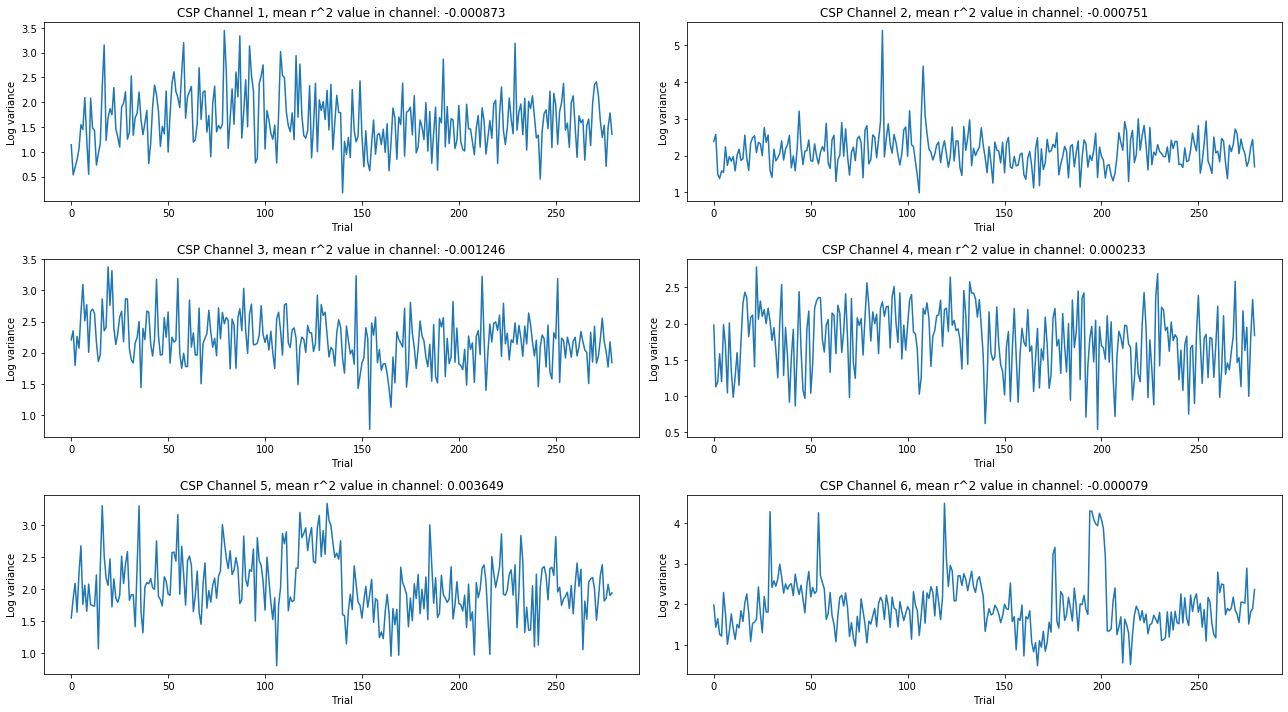

In [53]:
# based on difference graph above time interval 4000-4500ms is chosen
ival = [4000, 4500]
csp_epo, csp_epo_t = bci.makeepochs(cnt_csp_filtered, fs, mrk_pos, ival)

var = np.var(csp_epo,0)
log_var = np.log(var)
print(log_var.shape)

epo_r = signed_r_square(csp_epo, mrk_class)
print(epo_r.shape)

plt.figure(figsize=[18, 10])
nChans= cnt_csp_filtered.shape[0]
for i in range(nChans):
    plt.subplot(3,2,i+1)
    plt.plot(log_var[i,:])
    plt.title('CSP Channel %d, mean r^2 value in channel: %f' % (i+1,np.mean(epo_r[:,i])))
    plt.xlabel('Trial')
    plt.ylabel('Log variance')
    plt.tight_layout()


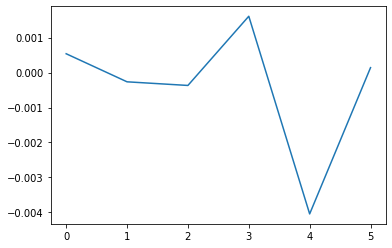

In [57]:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)

var = np.var(epo,0)
log_var = np.log(var)

epo_r_no_filter = signed_r_square(erd, mrk_class)
# print (epo_r_no_filter)
epo_r_no_filter = np.mean(epo_r_no_filter,axis=0)

plt.plot(epo_r_no_filter)

# bci.scalpmap(mnt, epo_r_no_filter)
# plt.title("r^2-values for each channel without CSP filter")